# Identifying Tweets About Emergencies with NLP
Group 21:
- David D'Souza
- Ann Soong

In [2]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

from tensorflow import keras, squeeze, round
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Input, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

# https://nlpretext.readthedocs.io/en/latest/
from nlpretext.basic.preprocess import normalize_whitespace, remove_punct, remove_eol_characters, remove_stopwords, \
  lower_text, remove_accents, remove_multiple_spaces_and_strip_text, replace_numbers, replace_emails, replace_urls
from nlpretext.social.preprocess import convert_emoji_to_text, remove_mentions, extract_mentions, remove_hashtag, extract_hashtags

from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

np.random.seed(42)

ModuleNotFoundError: No module named 'keras'

In [37]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [38]:
print(train_data.shape)
print(train_data["text"][5])
print(train_data["target"][5])

(7613, 5)
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
1


In [145]:
def clean_text(tweet):
    tmp = replace_urls(tweet, replace_with='')
    tmp = replace_emails(tmp, replace_with='')
    tmp = cleanup = convert_emoji_to_text(tmp)
    tmp = remove_accents(tmp)
    
    tweet_blob = TextBlob(tmp)
    tweet_blob = ' '.join(tweet_blob.words)
    tweet_blob = tweet_blob.lower()
    stopset = set(stopwords.words('english'))
    cleanup = " ".join(filter(lambda word: word not in stopset, tweet_blob.split()))
    
    cleanup = re.sub(r"\S*'\S*", "", cleanup) # Removes text that's linked to 1 apostrophe (i.e., 's, n't)
    cleanup = remove_punct(cleanup)
    cleanup = re.sub(r"\d+", "", cleanup)
    cleanup = remove_multiple_spaces_and_strip_text(cleanup)
    cleanup = normalize_whitespace(cleanup)
    return cleanup

print(clean_text(train_data["text"].iloc[31]))
print(train_data["text"].iloc[31])

bbcmtd wholesale markets ablaze
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C


In [147]:
# clean train data and save it to a csv
train_data['clean_text'] = train_data.text.apply(lambda x: clean_text(x))
train_data.to_csv('train_clean.csv')


In [ ]:
# clean test data and save it to a csv
test_data['clean_text'] = test_data.text.apply(lambda x: clean_text(x))
test_data.to_csv('test_clean.csv')

In [3]:
df = pd.read_csv("./train_clean.csv")
print(df.shape)

(7613, 7)


## Data Summarization

In [1]:
print(df.info())
 
# Display ratio of 0 to 1 (0 -> not disaster, 1 -> disaster)
table_ratio = df.groupby('target').count()['text'].reset_index().sort_values(by='text',ascending=False)
display(table_ratio)
fig_size = plt.figure(figsize=(6,6))
plt.pie(table_ratio['text'], labels=['0 - Non disaster', '1 - Disaster'])
plt.title('Ratio of non disaster tweets to disaster tweets')
plt.show()

# Display frequency of top 20 words in cleaned text
df['temp_word_list'] = df['clean_text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df['temp_word_list'] for item in sublist])
table_top = pd.DataFrame(top_words.most_common(20))
table_top.columns = ['Words','Frequency']
fig_size = plt.figure(figsize=(25,7))
plt.bar(table_top['Words'], table_top['Frequency'], color='green')
plt.xlabel('Word')
plt.ylabel('Frequency of word')
plt.title('Top 20 most frequent words in clean text')
plt.show()

# Display frequency of top words in non disaster clean text
fake_disaster = df[df['target']== 0]
top_words_fake = Counter([item for sublist in fake_disaster['temp_word_list'] for item in sublist])
table_top_fake = pd.DataFrame(top_words_fake.most_common(25))
table_top_fake.columns = ['Words','Frequency']
fig_size = plt.figure(figsize=(25,7))
plt.bar(table_top_fake['Words'], table_top_fake['Frequency'], color='purple')
plt.xlabel('Word')
plt.ylabel('Frequency of word')
plt.title('Top 25 most frequent words in non disaster clean text')
plt.show()

# Display frequency of keywords in disaster tweets
table_top_fake = fake_disaster.groupby('keyword').count()['target'].reset_index().sort_values(by='target',ascending=False)
fig_size = plt.figure(figsize=(25,7))
plt.bar(table_top_fake['keyword'][0:10], table_top_fake['target'][0:10], color='purple') #, labels=['0 - Non disaster', '1 - Disaster'])
plt.xlabel('Keyword')
plt.ylabel('Frequency of keyword')
plt.title('Frequency of keywords in non disaster tweets')
plt.show()

# Display frequency of top words in disaster clean text
real_disaster = df[df['target']== 1]
top_words_real = Counter([item for sublist in real_disaster['temp_word_list'] for item in sublist])
top_words_real = pd.DataFrame(top_words_real.most_common(25))
top_words_real.columns = ['Words','Frequency']
fig_size = plt.figure(figsize=(25,7))
plt.bar(top_words_real['Words'], top_words_real['Frequency'], color='orange')
plt.xlabel('Word')
plt.ylabel('Frequency of word')
plt.title('Top 25 most frequent words in disaster clean text')
plt.show()

# Display frequency of keywords in disaster tweets
table_keyword_real = real_disaster.groupby('keyword').count()['target'].reset_index().sort_values(by='target',ascending=False)
fig_size = plt.figure(figsize=(25,7))
plt.bar(table_keyword_real['keyword'][0:10], table_keyword_real['target'][0:10], color='orange') #, labels=['0 - Non disaster', '1 - Disaster'])
plt.xlabel('Keyword')
plt.ylabel('Frequency of keyword')
plt.title('Frequency of keywords in disaster tweets')
plt.show()

# Dropping temporary columns
df = df.drop(columns=['temp_word_list'])

NameError: name 'df' is not defined

## Data Preprocessing

The test data does not have a target column, so we cannot evaluate our models using the test data. We need to split the first dataset into a test and train dataset.

In [4]:
# split the data into train and test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(df, df['target']):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

print(df_train.shape)
print(df_test.shape)
print(df_train.target.value_counts()/len(df_train))
print(df_test.target.value_counts()/len(df_test))

(5329, 7)
(2284, 7)
0    0.570276
1    0.429724
Name: target, dtype: float64
0    0.57049
1    0.42951
Name: target, dtype: float64


In [5]:
# reset indexes
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [6]:
cleaned_train_text = list(df_train["clean_text"])
labels_train = list(df_train["target"])
cleaned_test_text = list(df_test["clean_text"])
labels_test = list(df_test["target"])

We replace the NaN values in the clean_text column with an empty string.

In [7]:
train_nan_indexes = df_train[df_train["clean_text"].isna()].index
for i in train_nan_indexes:
    cleaned_train_text[i] = ""

test_nan_indexes = df_test[df_test["clean_text"].isna()].index
for i in test_nan_indexes:
    cleaned_test_text[i] = ""

We tokenize the text and convert the text data into sequences that we can input into our deep learning models.

In [8]:
# tokenize the clean_text column
maxlen = 30
max_words = 100
vocab_size = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(cleaned_train_text)
sequences = tokenizer.texts_to_sequences(cleaned_train_text)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels_train)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 13324 unique tokens
Shape of data tensor: (5329, 30)
Shape of label tensor: (5329,)


We use the GloVe word embeddings file to pass into our models. The closer words are in the matrix, the more similar their meaning. The word embeddings file was downloaded from https://nlp.stanford.edu/projects/glove/

In [9]:
glove_dir = './'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Model Development

First, we create a simple RNN model. This model as one RNN layer. We then plot the model's training and validation accuracy and loss during model fitting.

In [15]:
model = keras.models.Sequential()
model.add(Input(shape=(None,)))
model.add(Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen
    ))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

early_stop = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    verbose=0,
    mode='min',
    baseline=None
)

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
history = model.fit(data, labels, validation_split=0.3, epochs=50, batch_size=64, callbacks=[reduce_lr,early_stop])


Epoch 1/50
59/59 [==============================] - 2s 10ms/step - loss: 0.6275 - accuracy: 0.6552 - val_loss: 0.6102 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 0s 7ms/step - loss: 0.5821 - accuracy: 0.6997 - val_loss: 0.6068 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 0s 7ms/step - loss: 0.5687 - accuracy: 0.7110 - val_loss: 0.6018 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 0s 7ms/step - loss: 0.5620 - accuracy: 0.7142 - val_loss: 0.6007 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 0s 7ms/step - loss: 0.5537 - accuracy: 0.7185 - val_loss: 0.5995 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 0s 6ms/step - loss: 0.5494 - accuracy: 0.7196 - val_loss: 0.6035 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 0s 6ms/step - loss: 0.5479 - 

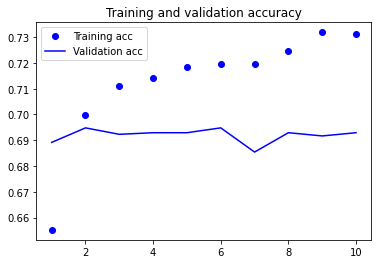

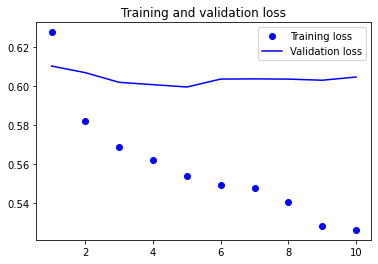

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We create a simple LSTM model. This model as one LSTM layer. We then plot the model's training and validation accuracy and loss during model fitting.

In [17]:
model2 = keras.models.Sequential()
model2.add(Input(shape=(None,)))
model2.add(Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen))
model2.add(LSTM(64))
model2.add(Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

early_stop = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    verbose=0,
    mode='min',
    baseline=None
)

model2.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
history2 = model2.fit(data, labels, validation_split=0.3, epochs=50, batch_size=64, callbacks=[reduce_lr,early_stop])

Epoch 1/50
59/59 [==============================] - 3s 25ms/step - loss: 0.6083 - accuracy: 0.6836 - val_loss: 0.6071 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 1s 19ms/step - loss: 0.5822 - accuracy: 0.6997 - val_loss: 0.6193 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 1s 19ms/step - loss: 0.5734 - accuracy: 0.7051 - val_loss: 0.5995 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 1s 19ms/step - loss: 0.5659 - accuracy: 0.7051 - val_loss: 0.5997 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 1s 18ms/step - loss: 0.5604 - accuracy: 0.7102 - val_loss: 0.5916 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 1s 18ms/step - loss: 0.5562 - accuracy: 0.7118 - val_loss: 0.5984 - val_accuracy: 0.6854 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 1s 18ms/step - loss: 0.5

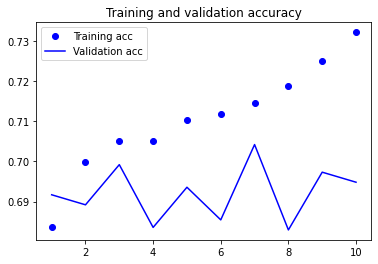

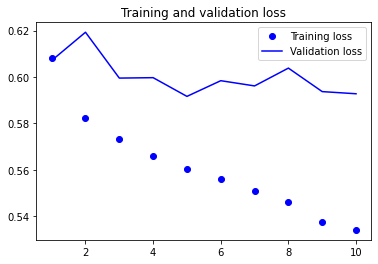

In [18]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
model3 = keras.models.Sequential()
model3.add(Input(shape=(None,)))
model3.add(Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen
    ))
model3.add(Dense(128))
model3.add(Dropout(0.5))
model3.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(Dense(128))
model3.add(Dropout(0.4))
model3.add(Bidirectional(SimpleRNN(64)))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

early_stop = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    verbose=0,
    mode='min',
    baseline=None
)

model3.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
history3 = model3.fit(data, labels, validation_split=0.3, epochs=50, batch_size=64, callbacks=[reduce_lr,early_stop])

Epoch 1/50
59/59 [==============================] - 5s 40ms/step - loss: 0.7116 - accuracy: 0.5895 - val_loss: 0.6701 - val_accuracy: 0.6773 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 2s 32ms/step - loss: 0.6730 - accuracy: 0.6442 - val_loss: 0.6199 - val_accuracy: 0.6904 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 2s 33ms/step - loss: 0.6392 - accuracy: 0.6603 - val_loss: 0.6254 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 2s 32ms/step - loss: 0.6334 - accuracy: 0.6544 - val_loss: 0.6250 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 2s 32ms/step - loss: 0.6234 - accuracy: 0.6694 - val_loss: 0.6364 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 2s 33ms/step - loss: 0.6239 - accuracy: 0.6764 - val_loss: 0.6264 - val_accuracy: 0.6992 - lr: 2.5000e-04
Epoch 7/50
59/59 [==============================] - 2s 32ms/step - loss:

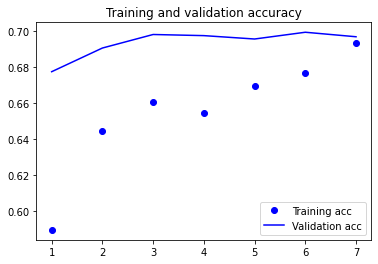

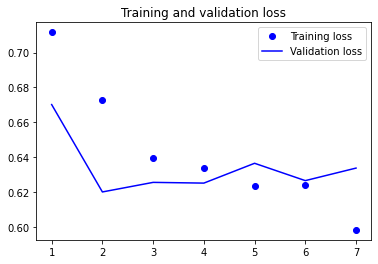

In [31]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
model4 = keras.models.Sequential()
model4.add(Input(shape=(None,)))
model4.add(Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen
    ))
model4.add(Dense(128))
model4.add(Dropout(0.5))
model4.add(Bidirectional(LSTM(64, return_sequences=True)))
model4.add(Dropout(0.5))
model4.add(Dense(128))
model4.add(Dropout(0.4))
model4.add(Bidirectional(LSTM(64)))
model4.add(Dropout(0.4))
model4.add(Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

early_stop = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    verbose=0,
    mode='min',
    baseline=None
)

model4.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
history4 = model4.fit(data, labels, validation_split=0.3, epochs=50, batch_size=64, callbacks=[reduce_lr,early_stop])

Epoch 1/50
59/59 [==============================] - 11s 92ms/step - loss: 0.6108 - accuracy: 0.6775 - val_loss: 0.6003 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 4s 67ms/step - loss: 0.5912 - accuracy: 0.6946 - val_loss: 0.6147 - val_accuracy: 0.6873 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 4s 67ms/step - loss: 0.5891 - accuracy: 0.6989 - val_loss: 0.6529 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 4s 68ms/step - loss: 0.5835 - accuracy: 0.7003 - val_loss: 0.6081 - val_accuracy: 0.6904 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 4s 70ms/step - loss: 0.5787 - accuracy: 0.6997 - val_loss: 0.5976 - val_accuracy: 0.6961 - lr: 2.5000e-04
Epoch 6/50
59/59 [==============================] - 4s 68ms/step - loss: 0.5724 - accuracy: 0.7102 - val_loss: 0.5934 - val_accuracy: 0.6973 - lr: 2.5000e-04
Epoch 7/50
59/59 [==============================] - 4s 67ms/step - 

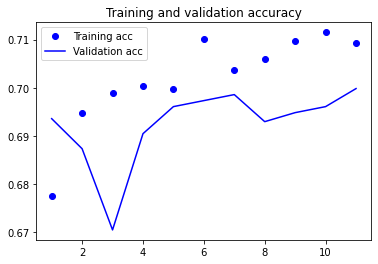

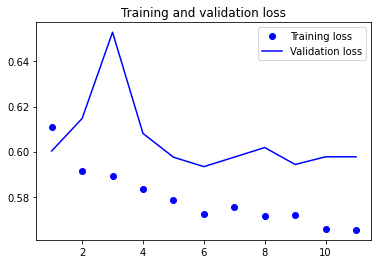

In [34]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluation

We tokenize the test data

In [15]:
# Tokenizing the test data split
test_tokenizer = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer.fit_on_texts(cleaned_test_text)
test_sequences = test_tokenizer.texts_to_sequences(cleaned_test_text)
test_data = pad_sequences(test_sequences, maxlen=maxlen)
labels_test = np.asarray(labels_test)


We then create classification reports for both the models.

In [48]:
test_evals = model.evaluate(test_data, labels_test)
predictions = model.predict(test_data)
predicted_lbls = squeeze(round(predictions))
print(predicted_lbls)
cr = classification_report(labels_test, predicted_lbls)
print(cr)

72/72 [==============================] - 0s 3ms/step - loss: 0.8401 - accuracy: 0.5447
tf.Tensor([1. 1. 0. ... 0. 0. 0.], shape=(2284,), dtype=float32)
              precision    recall  f1-score   support

           0       0.58      0.74      0.65      1303
           1       0.45      0.28      0.35       981

    accuracy                           0.54      2284
   macro avg       0.52      0.51      0.50      2284
weighted avg       0.52      0.54      0.52      2284



In [26]:
test_evals2 = model2.evaluate(test_data, labels_test)
predictions2 = model2.predict(test_data)
predicted_lbls2 = squeeze(round(predictions2))
cr2 = classification_report(labels_test, predicted_lbls2)
print(cr2)

72/72 [==============================] - 0s 5ms/step - loss: 0.8250 - accuracy: 0.5473
              precision    recall  f1-score   support

           0       0.58      0.72      0.65      1303
           1       0.46      0.31      0.37       981

    accuracy                           0.55      2284
   macro avg       0.52      0.52      0.51      2284
weighted avg       0.53      0.55      0.53      2284



In [32]:
test_evals3 = model3.evaluate(test_data, labels_test)
predictions3 = model3.predict(test_data)
predicted_lbls3 = squeeze(round(predictions3))
print(predicted_lbls3)
cr3 = classification_report(labels_test, predicted_lbls3)
print(cr3)

72/72 [==============================] - 1s 8ms/step - loss: 0.8987 - accuracy: 0.5595
tf.Tensor([1. 1. 0. ... 0. 0. 1.], shape=(2284,), dtype=float32)
              precision    recall  f1-score   support

           0       0.59      0.73      0.66      1303
           1       0.48      0.33      0.39       981

    accuracy                           0.56      2284
   macro avg       0.54      0.53      0.52      2284
weighted avg       0.54      0.56      0.54      2284



In [35]:
test_evals4 = model4.evaluate(test_data, labels_test)
predictions4 = model4.predict(test_data)
predicted_lbls4 = squeeze(round(predictions4))
print(predicted_lbls4)
cr4 = classification_report(labels_test, predicted_lbls4)
print(cr4)

72/72 [==============================] - 1s 20ms/step - loss: 0.8326 - accuracy: 0.5565
tf.Tensor([1. 1. 0. ... 0. 0. 0.], shape=(2284,), dtype=float32)
              precision    recall  f1-score   support

           0       0.59      0.75      0.66      1303
           1       0.47      0.30      0.37       981

    accuracy                           0.56      2284
   macro avg       0.53      0.52      0.51      2284
weighted avg       0.54      0.56      0.53      2284



The following is to create a submission for the Kaggle Competition. The Test data provided by Kaggle does not have a label. The predictions from the model are meant to be submitted to the competition.

In [22]:
# create a submission using test data
test_data_clean2 = pd.read_csv("test_clean.csv")
cleaned_test_text2 = list(test_data_clean2["clean_text"])
nanIndexes = test_data_clean2[test_data_clean2['clean_text'].isna()].index
for i in nanIndexes:
    cleaned_test_text2[i] = ""
test_tokenizer2 = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer2.fit_on_texts(cleaned_test_text2)
test_sequences2 = test_tokenizer.texts_to_sequences(cleaned_test_text2)
test_data2 = pad_sequences(test_sequences2, maxlen=maxlen)
predictions_test = model3.predict(test_data2)
predicted_lbls_test = squeeze(round(predictions_test))
predicted_lbls_test = list(map(lambda x: int(x), list(predicted_lbls_test.numpy())))
res = []
for i in test_data_clean2.index:
    res.append([test_data_clean2["id"][i], predicted_lbls_test[i]])
predictions_df = pd.DataFrame(res, columns=["id", "target"])
predictions_df.to_csv("./disaster_tweets_submission.csv", index=True)
